# Analyzing the Correlation of SPY Log Returns vs. Macro Indicators, Sept. 2014 - Sept. 2024 - Part I: Monthly Natural Log Returns  

### *By Blake Zenuni*

My github: https://github.com/BlakeBelisarius**   
Project in this repo: https://github.com/BlakeBelisarius/MacroMarketPulse**  
Yellowbrick Repo to produce visualizations for your machine learning workflow: https://github.com/BlakeBelisarius/yellowbrick**

---

### Overview

This project analyzes how the natural log returns of the S&P 500 (**SPY**) are correlated with two key macroeconomic indicators:  

0. **Why use natural log returns instead of standard (arithmetic) returns?**
   - **Time Additivity**: Log returns are additive across periods, making it easier to calculate multi-period returns.
   - **Symmetry**: Log returns treat price increases and decreases symmetrically, balancing up and down movements.
   - **Normality Assumption**: Log returns better approximate a normal distribution, useful for many financial models.
   - **Compounding**: Naturally account for continuous compounding, simplifying return calculations.
   - **Reduced Sensitivity to Large Movements**: Log returns lessen the impact of large price changes, making them more stable for volatile assets.
   - **Scalability**: Log returns can be easily scaled to different time intervals (e.g., annualizing daily returns).

   For more insights on log returns:
   - **ExplorePortfolio**: [Exploring Log Returns](https://exploreportfolio.com)
   - **Gregory Gundersen**: [Detailed Explanation](https://gregorygundersen.com/blog/2022/02/06/log-returns/)

1. **The Yield Curve**: Represented by the difference between the 10-Year and 2-Year Treasury rates (T10Y2Y).
2. **The 10-Year Treasury Constant Maturity Rate (GS10)**: A widely followed interest rate that serves as a benchmark for longer-term borrowing costs.

### Objectives:
- To understand how changes in macroeconomic factors such as interest rates and the yield curve impact stock market returns.
- To use statistics, correlation analysis, and exploratory data analysis (EDA) to quantify these relationships.
- To visualize the time series of these variables and analyze trends over time.

### Data Sources:
- **SPY Price Data**: SPY historical price data from Yahoo Finance.
- **Macroeconomic Data**: Yield Curve and GS10 Rate data from FRED (Federal Reserve Economic Data).

---  

### Methodology

1. **Data Collection**:
   - We fetched daily SPY price data from **Yahoo Finance** and daily **yield curve** and **GS10 rate** data from **FRED**.
   - Daily data allows us to later explore granular trends and behaviors, but for Part I, we focus on monthly analysis for better trend smoothing and long-term insight.

2. **Natural Log Returns**:
   - We calculated the **daily natural log returns** for SPY and resampled them to a monthly frequency by summing the daily log returns for each month. 
   - **Why Cumulative Log Returns?**: 
     - Cumulative log returns capture the **total performance** of SPY each month, aligning well with the monthly frequency of the macroeconomic data.
     - By using cumulative log returns, we ensure a more accurate representation of the relationship between SPY and macroeconomic indicators, as they reflect the complete market performance over the given period.

3. **Macroeconomic Data**:
   - The **GS10 rate** and **yield curve** were resampled to their **monthly mean**, which reflects the **average macroeconomic conditions** each month.
   - Unlike returns, interest rates and the yield curve don’t behave cumulatively, so using the monthly mean provides a more appropriate summary of macroeconomic conditions during the month.

### Steps:
1. Fetch and clean the data from Yahoo Finance and FRED.
2. Calculate the daily natural log returns for SPY, then resample the log returns to a monthly frequency by summing the daily returns. This ensures the SPY data is aligned with the monthly macroeconomic data (yield curve and GS10 rate).
   - **NB**: We are using **cumulative natural log returns** (instead of a monthly mean) to capture the **total monthly performance** of SPY. This aligns better with the monthly macroeconomic data and provides a clearer view of the relationship between market returns and macro factors, which may be less obvious in short-term daily fluctuations.
3. Perform exploratory data analysis (EDA) to visualize trends and relationships.
4. Conduct correlation analysis to quantify the relationships between the monthly cumulative SPY log returns and the two economic indicators.
5. Perform machine learning models (linear regression, polynomial regress, and random forest) to study any linear or non-linear patterns.

### Looking Ahead

- In **Part II**, we will replicate this analysis using **daily data** to gain **granularity** and capture **short-term dynamics**. This will allow us to examine how daily market fluctuations are influenced by the yield curve and interest rates, complementing the longer-term trends captured in the monthly analysis.
 + NB: Daily data will allow us to explore short-term volatility and immediate market responses to economic events, providing a more detailed view of how SPY returns are influenced by daily fluctuations in the yield curve and GS10 rate.

---  


### TLDR KEY-TAKEAWAYS:

- *Natural Log Returns*: We use cumulative **natural log returns** for SPY (also referred to as SPY Ln Returns) because they are additive across time, treat price changes symmetrically, and better approximate a normal distribution.  

- *Data Source & Macroeconomic Indicators*: Daily SPY price data was collected from **Yahoo Finance**, and daily **yield curve** (T10Y2Y) and **GS10 rate** data from **FRED**.  

- *Monthly Analysis*: For smoother insights and long-term trends, SPY log returns were resampled to **monthly cumulative returns**, while the macroeconomic indicators were resampled to their **monthly mean**.  

- *Why Monthly*: Monthly data aligns better with macroeconomic trends and avoids the noise of daily market fluctuations, making it ideal for long-term analysis.  

- *Correlation and Regression*: The analysis will focus on how the yield curve and GS10 rate impact SPY returns, using correlation and regression to quantify these relationships.  

- *Looking Ahead*: In **Part II**, we’ll conduct the same analysis using **daily data** for a more granular view of short-term market dynamics.


In [80]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import numpy as np

# Set visualization styles
sns.set_theme(style="whitegrid")

## Fetching Data

In this section, we will:
1. Retrieve SPY price data from Yahoo Finance.
2. Fetch the Yield Curve (10Y - 2Y spread) and the 10-Year Treasury Constant Maturity Rate (GS10) from the FRED API.
3. Clean and merge the datasets for further analysis.


In [81]:
# Fetch SPY data (daily data)
spy_data = yf.download('SPY', start='2014-09-27', end='2024-09-24')

# Calculate the natural log returns for SPY
spy_data['log_returns'] = np.log(spy_data['Adj Close'] / spy_data['Adj Close'].shift(1)) #NB: np.log() refers to natural log in Numpy (base e, super useful in finance!)

# Drop missing values (e.g., first row after shift)
spy_data.dropna(inplace=True)

# Resample SPY log returns to monthly frequency (sum log returns for each month)
# By summing the daily log returns, we obtain the cumulative natural log return for each month, which represents the total return over the entire month.
spy_monthly_returns = spy_data['log_returns'].resample('M').sum()
spy_monthly_returns.head(5)

[*********************100%***********************]  1 of 1 completed


Date
2014-09-30   -0.002636
2014-10-31    0.023278
2014-11-30    0.027102
2014-12-31   -0.002540
2015-01-31   -0.030077
Freq: M, Name: log_returns, dtype: float64

In [82]:
# Initialize Fred API (replace 'your_api_key_here' with your actual FRED API key)
fred = Fred(api_key='YOUR API HERE')  # Replace this with your FRED API key

# Fetch data for the Yield Curve (10-Year minus 2-Year Treasury Spread) and 10-Year Treasury rate (GS10)
# Since FRED API provides data at a daily frequency by default, we will ensure that any missing days are handled
yield_curve = fred.get_series('T10Y2Y', start='2014-09-27', end='2024-09-27')
gs10_rate = fred.get_series('GS10', start='2014-09-27', end='2024-09-27')

# Convert to a DataFrame for easier manipulation
economic_data = pd.DataFrame({
    'yield_curve': yield_curve,
    'gs10_rate': gs10_rate
})

# Reindex the data to ensure it's at a daily frequency (even if some dates are missing) and fill any missing values
economic_data = economic_data.asfreq('D')  # Set the frequency explicitly to daily ('D')
economic_data.interpolate(method='linear', inplace=True)  # Optionally interpolate missing values if needed

# Filter for the desired date range
economic_data = economic_data[(economic_data.index >= '2014-09-27') & (economic_data.index <= '2024-09-27')]

# Drop any remaining missing values (if applicable)
economic_data.dropna(inplace=True)

# Display the first few rows of economic data
economic_data.head(10)


,yield_curve,gs10_rate
2014-09-27,1.940000,2.330667
2014-09-28,1.930000,2.323000
2014-09-29,1.920000,2.315333
2014-09-30,1.940000,2.307667
2014-10-01,1.890000,2.300000
2014-10-02,1.910000,2.300968
2014-10-03,1.880000,2.301935
2014-10-04,1.883333,2.302903
2014-10-05,1.886667,2.303871
2014-10-06,1.890000,2.304839


## Merging SPY and Economic Data

Now that we have fetched the SPY log returns, the Yield Curve, and the GS10 rate, we will merge these datasets on the date index. This will allow us to analyze the relationships between SPY returns and the macroeconomic indicators over time.


In [83]:
#Resample SPY log returns to monthly frequency (cumulative sum for SPY log returns)
spy_monthly_returns = spy_data['log_returns'].resample('M').sum()

# Resample GS10 and yield curve to monthly frequency (taking the mean for each month)
gs10_monthly = economic_data['gs10_rate'].resample('M').mean()
yield_curve_monthly = economic_data['yield_curve'].resample('M').mean()

# Combine the monthly data for analysis
monthly_data = pd.DataFrame({
    'spy_monthly_returns': spy_monthly_returns,
    'gs10_rate': gs10_monthly,
    'yield_curve': yield_curve_monthly
})

# Drop any missing values (e.g., if some dates have incomplete data)
monthly_data.dropna(inplace=True)

# Display the first few rows of the combined dataset
monthly_data.tail(10)


,spy_monthly_returns,gs10_rate,yield_curve
2023-12-31,0.044644,4.039355,-0.429113
2024-01-31,0.015801,4.132581,-0.258952
2024-02-29,0.050871,4.210000,-0.336552
2024-03-31,0.032179,4.369677,-0.379355
2024-04-30,-0.041155,4.511000,-0.335333
2024-05-31,0.049342,4.397742,-0.377581
2024-06-30,0.034672,4.281000,-0.426000
2024-07-31,0.012036,4.066129,-0.249839
2024-08-31,0.023097,3.870000,-0.098387
2024-09-30,0.013633,3.870000,0.089630


In [84]:
# Check
spy_monthly_sum = monthly_data['spy_monthly_returns'].tail(5).sum()
print(spy_monthly_sum)

0.13278038492352368


---  

## Exploratory Data Analysis (EDA)

In this section, we will:
- Visualize the distributions (data shape)
- Visualize the time series of SPY log returns, the Yield Curve, and the 10-Year Treasury Rate (GS10).
- Investigate trends and patterns to better understand how these variables behave over time.


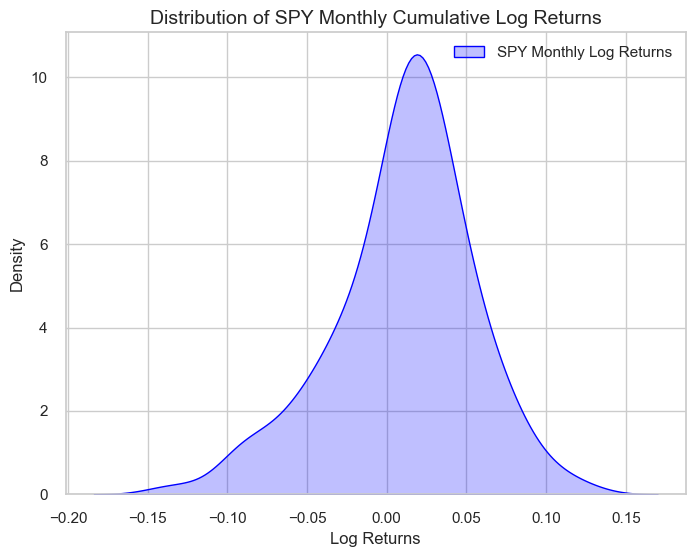

In [85]:
# Plot the distribution of SPY Log Returns using KDE
plt.figure(figsize=(8, 6))

# KDE plot for SPY Monthly Log Returns
sns.kdeplot(monthly_data['spy_monthly_returns'], color='blue', label='SPY Monthly Log Returns', fill=True)

# Title and labels
plt.title('Distribution of SPY Monthly Cumulative Log Returns', fontsize=14)
plt.xlabel('Log Returns')
plt.ylabel('Density')

# Show legend and grid
plt.legend()
plt.grid(True)
plt.show()


Distribution Insights from SPY Monthly Cumulative Ln Returns:
1. **SPY Ln Returns Distribution**
   - Centered around 0, with a slight positive skew.
   - Higher density near 0 suggests frequent small movements.
   - Occasional large positive and negative returns observed.

2. **Volatility**
   - Spread indicates periods of significant negative returns (left tail).
   - More frequent moderate positive returns compared to sharp losses.

3. **KDE Plot**
   - **KDE**: A smooth estimate of the distribution, showing data trends better than histograms.
   - Helps visualize skewness and spread of returns.

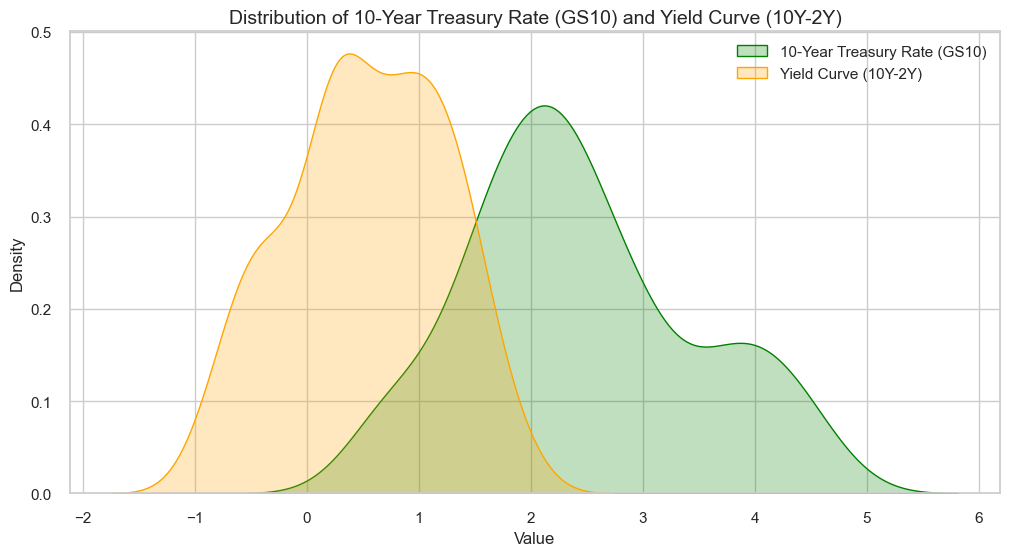

In [86]:
# Plot the distribution of GS10 and Yield Curve using KDE
plt.figure(figsize=(12, 6))

# KDE plot for GS10 Rate
sns.kdeplot(monthly_data['gs10_rate'], color='green', label='10-Year Treasury Rate (GS10)', fill=True)

# KDE plot for Yield Curve
sns.kdeplot(monthly_data['yield_curve'], color='orange', label='Yield Curve (10Y-2Y)', fill=True)

# Title and labels
plt.title('Distribution of 10-Year Treasury Rate (GS10) and Yield Curve (10Y-2Y)', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend and grid
plt.legend()
plt.grid(True)
plt.show()

Shape of GS10 and Yield Curve
1. **GS10 Rate**
   - Skewed slightly right, centered around 2-3%.
   - Higher density in the 2-4% range, indicating frequent fluctuations within this range.

2. **Yield Curve (10Y-2Y)**
   - Skewed left, centered around 0-1%.
   - Significant density below 0, indicating periods of yield curve inversion.

3. **Comparison**
   - GS10 rate generally higher than the yield curve, especially post-2014.
   - Yield curve more likely to go negative, reflecting inversion trends.

4. Why Use KDEs Here
   - Smooth Representation**: KDEs provide a continuous, smoothed view of the data distribution, making it easier to see the overall trend of the **GS10** and **Yield Curve** distributions compared to a more granular histogram.
   - Comparison of Distributions**: The overlapping KDEs allow for a direct visual comparison of the distributions of GS10 and the Yield Curve, helping to quickly identify where their values frequently occur and how they differ.

Index(['spy_monthly_returns', 'gs10_rate', 'yield_curve'], dtype='object')


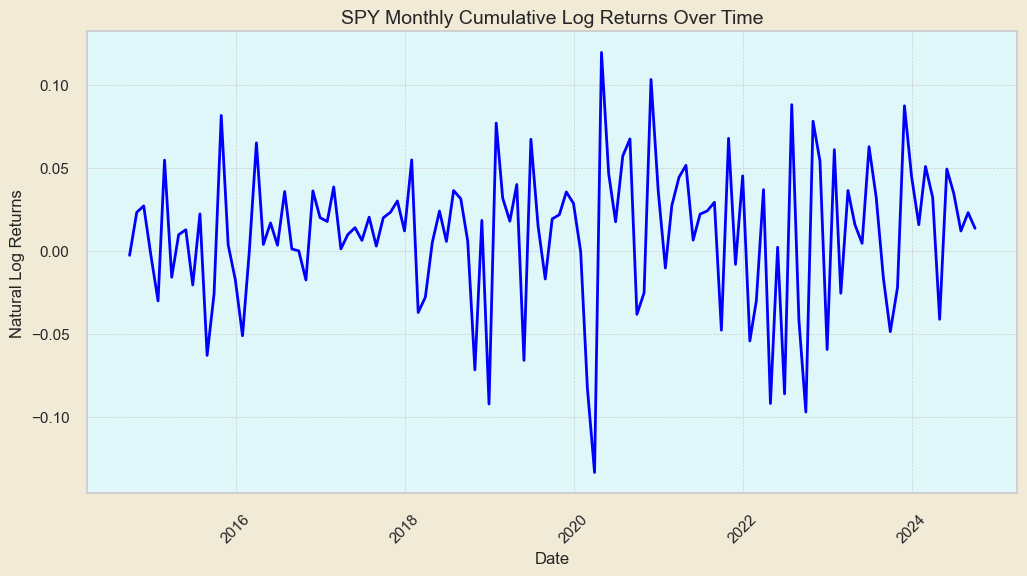

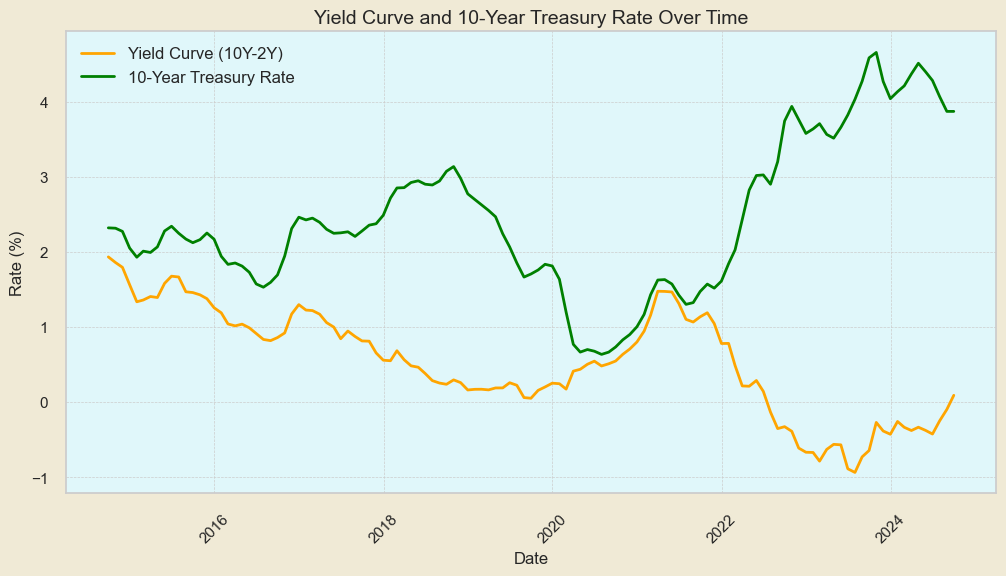

In [87]:
# For Jupyter notebooks: display plots inline
%matplotlib inline

# Check if 'spy_monthly_returns', 'yield_curve', and 'gs10_rate' columns exist in the monthly_data DataFrame
print(monthly_data.columns)

# Set custom colors for background and plot area
plt.rcParams['axes.facecolor'] = '#E0F7FA'  # Super light blue inside plot area (Hex color)
plt.rcParams['figure.facecolor'] = '#F0EAD6'  # Eggshell background color (Hex color)

# Enhanced plot for SPY monthly cumulative log returns over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['spy_monthly_returns'], label='SPY Monthly Log Returns', color='blue', linewidth=2)

# Add gridlines, title, and enhanced labels
plt.title('SPY Monthly Cumulative Log Returns Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Natural Log Returns', fontsize=12)

# Rotate x-axis ticks for better readability
plt.xticks(rotation=45)

# Add gridlines and slightly space out major x-axis ticks for better clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the first plot
plt.show()

# Enhanced plot for the yield curve and GS10 rate over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['yield_curve'], label='Yield Curve (10Y-2Y)', color='orange', linewidth=2)
plt.plot(monthly_data.index, monthly_data['gs10_rate'], label='10-Year Treasury Rate', color='green', linewidth=2)

# Add gridlines, title, and enhanced labels
plt.title('Yield Curve and 10-Year Treasury Rate Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)

# Rotate x-axis ticks for better readability and space out ticks
plt.xticks(rotation=45)

# Add a legend and customize gridlines for better readability
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the second plot
plt.show()

# Reset plt.rcParams to default to avoid affecting future plots
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

Summary of Trends Over the Last 10 Years:
1. **SPY**
   - Visible spikes in volatility around key market events, especially in 2020, reflecting the impact of the COVID-19 pandemic and market corrections.
   - Some periods of sharp negative returns (e.g., early 2020), but still SPY shows consistent positive movements, indicating recovery and growth in subsequent months.
   - Overall, the cumulative monthly natural log returns show the cyclical nature of market performance, having both periods of sharp gains and sharp losses.

2. **Yield Curve (10Y-2Y)**
   - Significant flattening since 2018, with deeper inversions in recent years.
   - Inversions in 2019 and 2022-2023 indicate rising recession concerns during those periods.

3. **10-Year Treasury Rate (GS10)**
   - Declined steadily from 2014 to 2020, hitting its lowest point during the pandemic, reflecting a low-interest-rate environment.
   - Sharp rise from 2021 onward, driven by inflationary pressures and the Fed's monetary tightening.

---  
   

## Correlation Analysis:
- **Visualize Correlations**: Heatmap showing correlations between SPY log returns, GS10 rate, and Yield Curve.
- **Key Findings**: Weak correlation between SPY and macro indicators; strong negative correlation between GS10 and Yield Curve.
- **Regression Plot**: Scatter plot with regression line showing clear negative relationship between GS10 and Yield Curve.

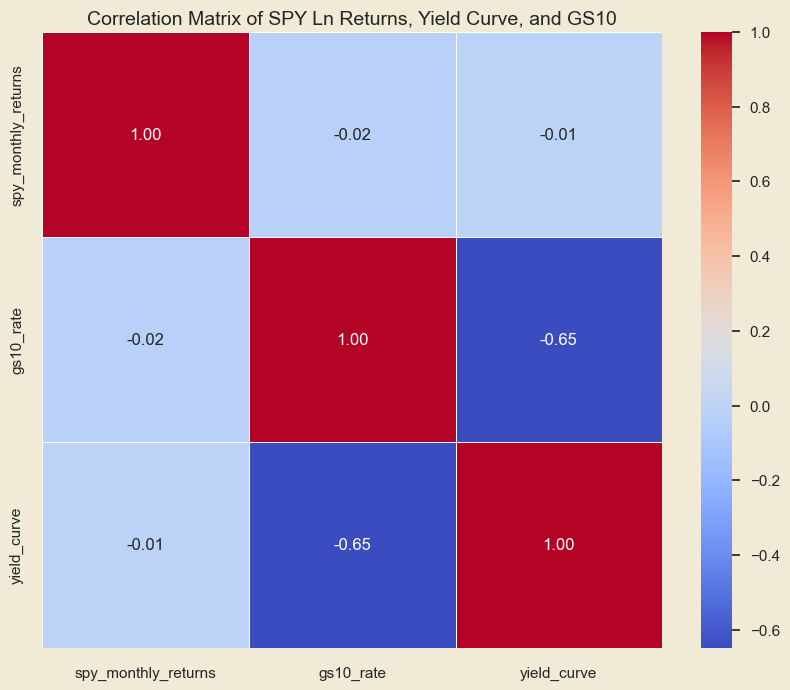

In [93]:
# Create a correlation matrix
corr_matrix = monthly_data.corr()
# Plot the heatmap with eggshell background for the figure
plt.figure(figsize=(10, 8))

# Set the figure background color to eggshell
plt.gcf().set_facecolor('#F0EAD6')  # Eggshell color for the outside
# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# Set the title
plt.title('Correlation Matrix of SPY Ln Returns, Yield Curve, and GS10', fontsize=14)
# Display the heatmap
plt.show()

Correlation Insights
- **SPY Log Returns**: Weak correlation with **GS10** (-0.02) and **Yield Curve** (-0.01).
- **GS10 Rate & Yield Curve**: Strong negative correlation (-0.65); as GS10 increases, yield curve flattens/inverts.
- Minimal relationship between SPY returns and macro indicators, suggesting other factors at play.

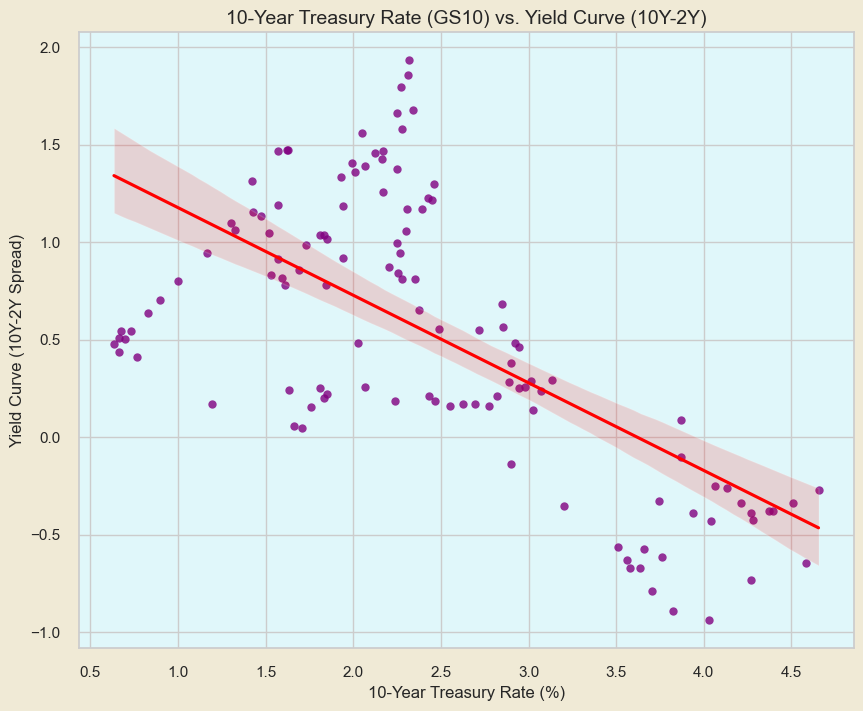

In [89]:
# Scatter plot with regression line for GS10 vs. Yield Curve
plt.figure(figsize=(10, 8))

# Set the figure background color to eggshell (outside) and the plot area to super light blue (inside)
plt.gcf().set_facecolor('#F0EAD6')  # Eggshell for the outside
plt.gca().set_facecolor('#E0F7FA')  # Super light blue for the inside

# Create the scatter plot with regression line
sns.regplot(x=monthly_data['gs10_rate'], y=monthly_data['yield_curve'], scatter_kws={'color': 'purple'}, line_kws={'color': 'red'})

# Set the title and axis labels
plt.title('10-Year Treasury Rate (GS10) vs. Yield Curve (10Y-2Y)', fontsize=14)
plt.xlabel('10-Year Treasury Rate (%)')
plt.ylabel('Yield Curve (10Y-2Y Spread)')

# Display the grid and show the plot
plt.grid(True)
plt.show()


Insights from GS10 vs. Yield Curve Scatter Plot
- **Negative correlation**: Clear negative relationship between GS10 and Yield Curve; as GS10 increases, the curve tends to invert.
- **Linear fit**: The regression line shows a strong downward trend, confirming the inverse relationship.
- **Outliers**: Some deviation from the line, especially at lower GS10 values (below 2%), suggests variability in the yield curve response.

---  

## Machine Learning Models: Linear Regression, Polynomial Regression, and Random Forest

In this section, we will explore different machine learning models to assess the relationship between SPY log returns and macroeconomic indicators (GS10 and Yield Curve):

1. **Linear Regression**: Start with a simple linear model to establish a baseline.
2. **Polynomial Regression**: Introduce non-linearity to capture potential hidden patterns.
3. **Random Forest**: Apply a tree-based method to explore complex, non-linear relationships.


Intercept: 0.02237312467555236
Coefficients: [-0.00415491 -0.00343477]
R-squared on training data: 0.004986171390189531
R-squared on testing data: -0.023332156671471038


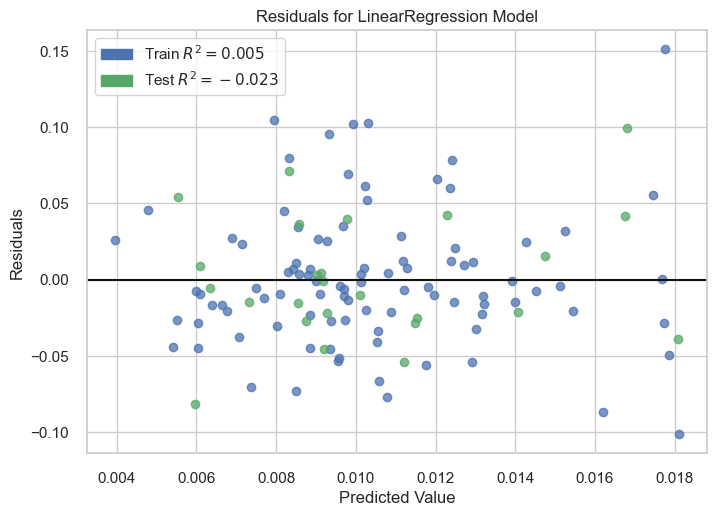

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [90]:
# Prepare the data
X = monthly_data[['gs10_rate', 'yield_curve']]  # Independent variables
y = monthly_data['spy_monthly_returns']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

# Print the regression results
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R-squared on training data:", model.score(X_train, y_train))
print("R-squared on testing data:", model.score(X_test, y_test))

# Visualize the regression results using Yellowbrick
visualizer = ResidualsPlot(model, hist=False)

# Fit the model and visualize
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

Lin Regression Summary
- The linear regression confirms the weak relationship between SPY log returns and the macroeconomic indicators (**GS10** and **Yield Curve**).
- **Quantified results**: The regression coefficients suggest minimal influence of these variables on SPY returns.
- **Takeaway**: Even weak relationships can provide insights, especially when regression models quantify the (limited) influence of macroeconomic variables on SPY log returns. It confirms that either the relationship is indeed weak or offers insight into more complex patterns that simpler models may not capture.

Next, let's try a more sophisticated model, a Polynomial Regression, to see if we can capture any non-linear relationships.

Intercept: 0.035739343796301504
Coefficients: [ 0.         -0.02240616  0.00684051  0.00336153 -0.00758466  0.01059963]
R-squared on training data: 0.04611000492223072
R-squared on testing data: -0.1819248310938275


-0.1819248310938275

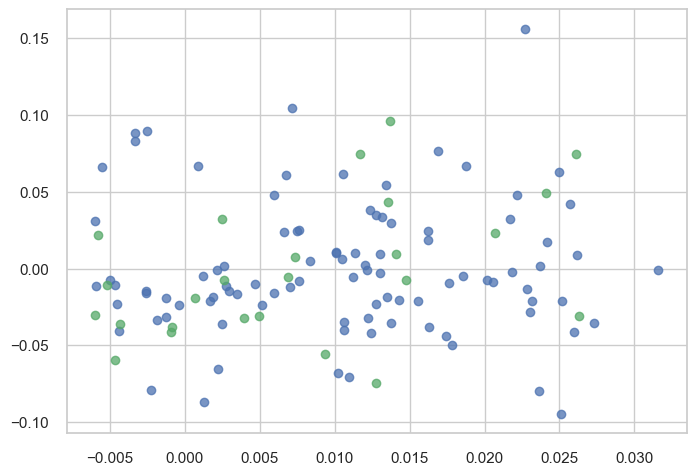

In [91]:
import warnings
warnings.filterwarnings('ignore')

# Prepare the data
X = monthly_data[['gs10_rate', 'yield_curve']]  # Independent variables
y = monthly_data['spy_monthly_returns']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features (degree 3for cubic, you can try higher degrees if needed but be cautios as it can lead to overfitting)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a linear regression model to fit the polynomial features
poly_model = LinearRegression()

# Fit the model
poly_model.fit(X_train_poly, y_train)

# Print the regression results
print("Intercept:", poly_model.intercept_)
print("Coefficients:", poly_model.coef_)
print("R-squared on training data:", poly_model.score(X_train_poly, y_train))
print("R-squared on testing data:", poly_model.score(X_test_poly, y_test))

# Visualize the polynomial regression results using Yellowbrick
visualizer = ResidualsPlot(poly_model, hist=False)

# Fit the model and visualize
visualizer.fit(X_train_poly, y_train)
visualizer.score(X_test_poly, y_test)

Polynomial Regression Summary
- The polynomial regression confirms a weak relationship between SPY log returns and the macroeconomic indicators (**GS10** and **Yield Curve**).
- **Quantified results**: With an R-squared of **0.046** on training data and **-0.182** on testing data, the model demonstrates poor predictive power, with a tendency to overfit the training data but fail to generalize.
- **Coefficients**: The polynomial features' coefficients are close to zero, highlighting the minimal impact of the macroeconomic factors on SPY returns.
- **Takeaway**: Even weak relationships can offer valuable insights. In this case, the results confirm that GS10 and the Yield Curve exert limited influence on SPY returns. This suggests either weak relationships or points to the need for more advanced modeling techniques to capture potentially hidden non-linear patterns in the data.

Next, let's try one more Machine Learning model, a random forrest model, to see if we can pick up on non-linear patterns that aren't apparant from the regressions above. Then, to close shop, we'll compare the Random Forest to the previous models.

Random Forest R-squared on Training Data: 0.8072345968163053
Random Forest R-squared on Testing Data: -0.18607305163744403
Random Forest MSE on Testing Data: 0.001962693967005713


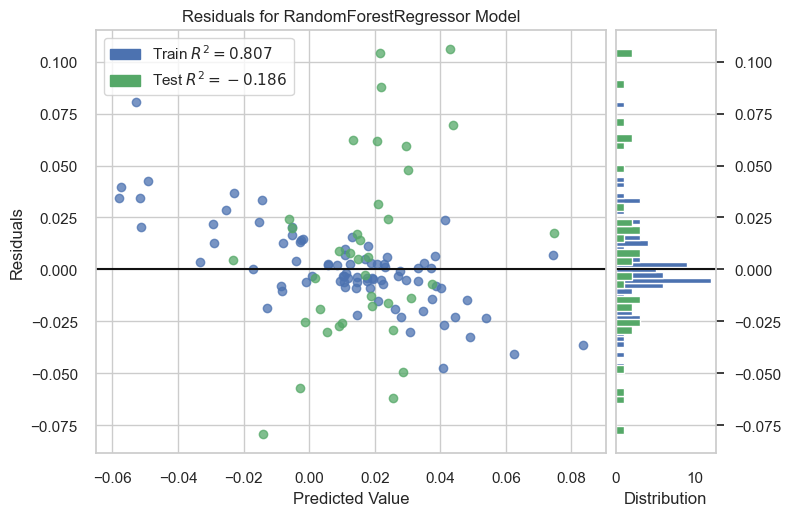

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [92]:
# Define the feature matrix (X) and target (y)
X = monthly_data[['gs10_rate', 'yield_curve']]  # Original features
y = monthly_data['spy_monthly_returns']  # Target (SPY log returns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Print R-squared and MSE for both training and testing data
print("Random Forest R-squared on Training Data:", r2_score(y_train, y_train_pred_rf))
print("Random Forest R-squared on Testing Data:", r2_score(y_test, y_test_pred_rf))
print("Random Forest MSE on Testing Data:", mean_squared_error(y_test, y_test_pred_rf))

# Visualize the residuals for the Random Forest model
visualizer_rf = ResidualsPlot(rf_model)
visualizer_rf.fit(X_train, y_train)
visualizer_rf.score(X_test, y_test)
visualizer_rf.show()


Random Forest Regression Summary
- The Random Forest model fits the training data well, with an R-squared of **0.807**, indicating the model captures much of the variance in SPY log returns when using **GS10** and **Yield Curve** as predictors.
- **Overfitting**: The model significantly overfits, as shown by the **-0.186** R-squared on testing data, indicating poor generalization. Despite capturing non-linear relationships better than linear models, it fails to generalize well.
- **Mean Squared Error (MSE)**: The **MSE** on the test data is **0.00196**, reflecting relatively low prediction errors, but the negative R-squared emphasizes that the predictions lack reliability.
- **Comparison to Regression Models**:
   - The Random Forest performs better on training data than both the **Linear** and **Polynomial** regression models, suggesting it captures more complexity.
   - However, on test data, it underperforms compared to even the **Polynomial Regression** (R-squared of **-0.182**) and suffers from the same issue of overfitting. This indicates that the macroeconomic variables (GS10 and Yield Curve) provide limited predictive value, regardless of model complexity.
- **Takeaway**: The Random Forest model reinforces the weak relationship between macroeconomic factors and SPY log returns. While it captures non-linearities, it struggles to generalize to unseen data, similar to the simpler regression models.

---  

## Closing Shop
- **Data & Methodology**: We resampled SPY log returns to a monthly frequency and paired it with macroeconomic data (GS10 and Yield Curve), performing cumulative log return analysis to align with monthly macroeconomic trends.
  
- **EDA & Correlation**: Exploratory analysis showed weak correlations between SPY log returns and macro indicators (Yield Curve: **-0.01**, GS10: **-0.02**), with a notable strong negative correlation between GS10 and the Yield Curve (**-0.65**).

- **Modeling Results**: 
  - **Linear Regression**: Confirmed weak relationships, with R-squared values near zero on both training and test data.
  - **Polynomial Regression**: Showed slight improvement on training data but failed to generalize, further confirming the limited predictive power of GS10 and Yield Curve.
  - **Random Forest**: Captured non-linear patterns well in training but struggled with overfitting, underperforming on test data with a negative R-squared.

- **Model Refinement**: Future improvements can include adding more features (e.g., inflation, unemployment, VIX) to better capture market behavior, and exploring hyperparameter tuning or ensemble methods to reduce overfitting.

- **Advanced Techniques**: Consider regularization methods (e.g., Lasso, Ridge), more robust cross-validation, or experimenting with time-series models to better handle the financial data's temporal dependencies.
